In [19]:
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy, pandas, shapefile

In [2]:
# Not currently used, but don't feel like deleting quite yet

theseCols = ['YEAR', 'TRI_FACILITY_ID', 'FACILITY_NAME', 'STREET_ADDRESS', 'CITY', 'ST', 'ZIP', 'INDUSTRY_SECTOR', 'CARCINOGEN', 'LATITUDE', 'LONGITUDE', 'CHEMICAL', 'UNIT_OF_MEASURE', 'ON-SITE_RELEASE_TOTAL']

## Importing Data

So I know this isn't the most effecient way to do this. I tried using the individual NC tri reports, but there was some strange issue where I was getting duplicate entries reading the NC reports vs the US reports. So I'm doing it the long way. :/

In [3]:
tri2011 = pandas.read_csv("DATA/TRI_DATA/TRI_2011_US.csv", usecols=theseCols)
tri2012 = pandas.read_csv("DATA/TRI_DATA/TRI_2012_US.csv", usecols=theseCols)
tri2013 = pandas.read_csv("DATA/TRI_DATA/TRI_2013_US.csv", usecols=theseCols)
tri2014 = pandas.read_csv("DATA/TRI_DATA/TRI_2014_US.csv", usecols=theseCols)
tri2015 = pandas.read_csv("DATA/TRI_DATA/TRI_2015_US.csv", usecols=theseCols)
tri2016 = pandas.read_csv("DATA/TRI_DATA/TRI_2016_US.csv", usecols=theseCols)

nc2011 = tri2011[(tri2011['ST'] == 'NC')].copy()
nc2012 = tri2012[(tri2012['ST'] == 'NC')].copy()
nc2013 = tri2013[(tri2013['ST'] == 'NC')].copy()
nc2014 = tri2014[(tri2014['ST'] == 'NC')].copy()
nc2015 = tri2015[(tri2015['ST'] == 'NC')].copy()
nc2016 = tri2016[(tri2016['ST'] == 'NC')].copy()

nc2011.index = range(len(nc2011.index))
nc2012.index = range(len(nc2012.index))
nc2013.index = range(len(nc2013.index))
nc2014.index = range(len(nc2014.index))
nc2015.index = range(len(nc2015.index))
nc2016.index = range(len(nc2016.index))

nc_data = [nc2011, nc2012, nc2013, nc2014, nc2015, nc2015, nc2016]

In [4]:
def dropAndConvert(frame):
    #Initialize a list to track the indexes of 0 on-site release reports
    noOnSite = []
    
    #Iterate through the rows in the frame and find the rows with a 0 in the On-Site Release field
    for i in frame.index:
        if frame.iloc[i]['ON-SITE_RELEASE_TOTAL']  == 0:
            noOnSite.append(frame.iloc[i].name)
        if frame.loc[i, ('UNIT_OF_MEASURE')] == 'Grams':
            frame.loc[i, ('ON-SITE_RELEASE_TOTAL')] *= 0.00220462
            frame.loc[i, ('UNIT_OF_MEASURE')] = 'Pounds'
            
    #Return a new dataframe with those entries dropped from the original frame
    return frame.drop(noOnSite)

In [5]:
for i in range(len(nc_data)):
    nc_data[i] = dropAndConvert(nc_data[i])

In [6]:
#code, charts and graphs related to top releasing facilities
sectors = [yr[['INDUSTRY_SECTOR', 'CHEMICAL','ON-SITE_RELEASE_TOTAL']] for yr in nc_data]
sectors[0].groupby(['INDUSTRY_SECTOR','CHEMICAL']).sum().sort_values('ON-SITE_RELEASE_TOTAL', ascending=False)

ON-SITE_RELEASE_TOTAL
INDUSTRY_SECTOR                   CHEMICAL                                                                 
Food                              NITRATE COMPOUNDS                                            6.631917e+06
Electric Utilities                HYDROCHLORIC ACID (1995 AND AFTER ACID AEROSOLS...           6.461584e+06
Paper                             METHANOL                                                     5.131813e+06
Electric Utilities                BARIUM COMPOUNDS                                             3.064782e+06
                                  SULFURIC ACID (1994 AND AFTER ACID AEROSOLS" ON...           1.932041e+06
Other                             NITRATE COMPOUNDS                                            1.599532e+06
Chemicals                         AMMONIA                                                      1.495001e+06
Electric Utilities                VANADIUM COMPOUNDS                                           1.118930e+06
Chemicals                         ZINC COMPOUNDS                                               9.286145e+05
Paper                             AMMONIA                                                      8.205590e+05
Chemicals                         CHROMIUM COMPOUNDS(EXCEPT CHROMITE ORE MINED IN...           8.202871e+05
Wood Products                     METHANOL                                                     7.850520e+05
Food                              N-HEXANE                                                     6.925936e+05
Electric Utilities                MANGANESE COMPOUNDS                                          6.276155e+05
Chemicals                         MANGANESE COMPOUNDS                                          5.864709e+05
                                  VANADIUM COMPOUNDS                                           5.859687e+05
Electric Utilities                CHROMIUM COMPOUNDS(EXCEPT CHROMITE ORE MINED IN...           5.848149e+05
Chemicals                         NITRATE COMPOUNDS                                            5.566718e+05
Paper                             MANGANESE COMPOUNDS                                          5.501580e+05
Fabricated Metals                 CERTAIN GLYCOL ETHERS                                        5.406380e+05
Electric Utilities                COPPER COMPOUNDS                                             5.366673e+05
                                  ZINC COMPOUNDS                                               5.351360e+05
                                  HYDROGEN FLUORIDE                                            5.212424e+05
Paper                             TOLUENE                                                      5.009740e+05
Electric Utilities                NICKEL COMPOUNDS                                             4.727560e+05
Chemicals                         METHANOL                                                     4.566593e+05
Food                              AMMONIA                                                      4.222888e+05
Other                             LEAD COMPOUNDS                                               4.114077e+05
                                  COPPER                                                       3.932090e+05
Chemicals                         ETHYLENE GLYCOL                                              3.868573e+05
...                                                                                                     ...
Computers and Electronic Products MERCURY                                                      1.000000e+00
Other                             ALUMINUM (FUME OR DUST)                                      1.000000e+00
Nonmetallic Mineral Product       MERCURY COMPOUNDS                                            9.000000e-01
Plastics and Rubber               CERTAIN GLYCOL ETHERS                                        8.100000e-01
Transportation Equipment          LEAD COMPOUNDS                                          

In [7]:
def consolidateLocations(frame):
    # Make new dataframe
    resultFrame = pandas.DataFrame(columns = theseCols)
    
    for i in frame.index:
        # If the facility is not currently listed in our new data frame, add it to the data frame
        if not frame.loc[i, ('TRI_FACILITY_ID')] in resultFrame['TRI_FACILITY_ID'].values:
            resultFrame.loc[len(resultFrame.index)] = frame.loc[i]
        else:
            # Otherwise, get the facilities location in the resultFrame
            targInd = resultFrame.index[resultFrame['TRI_FACILITY_ID'] == frame.loc[i, ('TRI_FACILITY_ID')]]
            # Add its on-site releases to the new total
            resultFrame.loc[targInd, ('ON-SITE_RELEASE_TOTAL')] += frame.loc[i, ('ON-SITE_RELEASE_TOTAL')]
            # Add its chemical to a list of all chemicals released at that location
            resultFrame.loc[targInd, ('CHEMICAL')] += ',' + frame.loc[i, ('CHEMICAL')]
            
    return resultFrame

In [8]:
for i in range(len(nc_data)):
    nc_data[i] = consolidateLocations(nc_data[i])

In [9]:
#separating out attributes of interest
totalreleases = [yr[['YEAR','FACILITY_NAME','LATITUDE','LONGITUDE','CHEMICAL','ON-SITE_RELEASE_TOTAL']] for yr in nc_data]
topten_byyear = [totalreleases[i].sort_values('ON-SITE_RELEASE_TOTAL', ascending=False)[0:10] for i in range(len(totalreleases))]
topten_byyear[0]

,YEAR,FACILITY_NAME,LATITUDE,LONGITUDE,CHEMICAL,ON-SITE_RELEASE_TOTAL
131,2011,PCS PHOSPHATE CO INC,35.377450,-76.778816,"ARSENIC COMPOUNDS,ZINC COMPOUNDS,POLYCYCLIC AR...",3.985817e+06
62,2011,INTERNATIONAL PAPER RIEGELWOOD MILL,34.352200,-78.212500,"MERCURY COMPOUNDS,ACETALDEHYDE,CATECHOL,CHLORI...",3.540676e+06
0,2011,DUKE ENERGY CAROLINAS LLC - MARSHALL STEAM STA...,35.597500,-80.965800,"HYDROGEN FLUORIDE,AMMONIA,MANGANESE COMPOUNDS,...",2.605915e+06
244,2011,SMITHFIELD-TAR HEEL,34.746500,-78.806100,"METHANOL,AMMONIA,NITRATE COMPOUNDS,CHLORINE DI...",2.539726e+06
75,2011,DUKE ENERGY CAROLINAS LLC - BELEWS CREEK STEAM...,36.281338,-80.059438,"SELENIUM COMPOUNDS,MERCURY COMPOUNDS,BARIUM CO...",2.535549e+06
20,2011,DUKE ENERGY PROGRESS LLC - ROXBORO STEAM ELECT...,36.483300,-79.073100,"COBALT COMPOUNDS,MANGANESE COMPOUNDS,POLYCYCLI...",2.533691e+06
11,2011,LEWISTON PROCESSING PLANT,36.141890,-77.219390,NITRATE COMPOUNDS,2.528732e+06
197,2011,BLUE RIDGE PAPER PRODUCTS INC (DBA EVERGREEN P...,35.535600,-82.841900,"BARIUM COMPOUNDS,MERCURY COMPOUNDS,CRESOL (MIX...",2.146294e+06
45,2011,ELEMENTIS CHROMIUM INC,34.372516,-77.859466,"NICKEL COMPOUNDS,BENZO(G,H,I)PERYLENE,POLYCYCL...",1.955988e+06
7,2011,DUKE ENERGY PROGRESS LLC - L V SUTTON ENERGY C...,34.283317,-77.985226,"HYDROGEN FLUORIDE,CHROMIUM COMPOUNDS(EXCEPT CH...",1.862391e+06


In [22]:
sf = shapefile.Reader('DATA/GIS_DATA/NC_Public_water/pwsws')
ncwater = sf.records()

ncwater

[[1,
  '0123010',
  70176.0,
  'S02',
  'S',
  'BROAD RIVER',
  'OFF OF HONEY HAVEN FARM RD',
  datetime.date(2003, 7, 1),
  'E',
  '',
  '',
  '',
  'CLEVELAND',
  'MOORESVILLE REGIONAL OFFICE',
  'C',
  'SHELBY, CITY OF',
  '801 W GROVER STREET',
  'SHELBY',
  'NC',
  '28150',
  '801 W GROVER STREET',
  '23',
  10090.0,
  21263.0,
  12000000.0,
  5301000.0,
  12000000.0,
  7615000.0,
  'CITY OF SHELBY',
  'PO BOX 207',
  'ATTN  DAVID HUX, WATER RESOURCES DIR',
  'SHELBY',
  'NC',
  '28151',
  '',
  '',
  'WS-IV',
  'H',
  'Direct Stream',
  '',
  0,
  '',
  'Serves 15+ connections or regularly serves 25+ year-round residents. ex. cities, towns, subdivisions.',
  'Community'],
 [2,
  '0195101',
  39184.0,
  'RW2',
  'S',
  'HOWARDS CREEK',
  'OFF HOWARDS CREEK RD',
  datetime.date(1977, 6, 1),
  'E',
  'M',
  '',
  '',
  'WATAUGA',
  'WINSTON-SALEM REGIONAL OFFICE',
  'C',
  'APPALACHIAN STATE UNIV WTP',
  '800 RAINBOW TRAIL',
  'BOONE',
  'NC',
  '28608',
  'ST OWNED COMMUNITY SURFAC

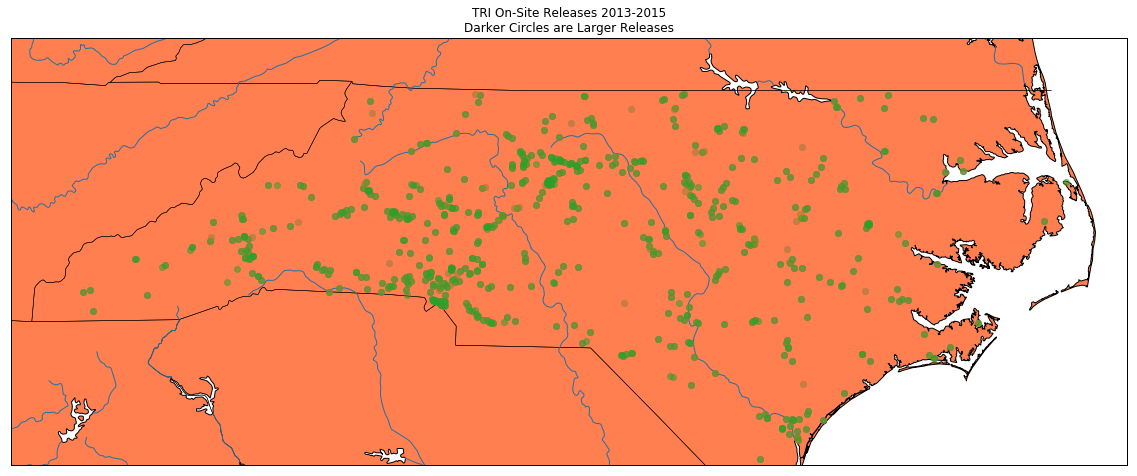

In [13]:
plt.figure(figsize = (20,20))

nc = Basemap(projection='merc', resolution='h',
             llcrnrlon = -84.5, urcrnrlon = -75.2,
             llcrnrlat = 34.0, urcrnrlat = 36.9)

nc.drawcountries()
nc.drawstates()
nc.drawcoastlines()
nc.drawrivers(linewidth = 1, color='#2471a3')
nc.fillcontinents(color = 'coral')
nc.drawmapboundary()

    
x13, y13 = nc(totalreleases[4].LONGITUDE.values, totalreleases[4].LATITUDE.values)
x14, y14 = nc(totalreleases[5].LONGITUDE.values, totalreleases[5].LATITUDE.values)
x15, y15 = nc(totalreleases[6].LONGITUDE.values, totalreleases[6].LATITUDE.values)


nc.scatter(x13, y13, marker='o', alpha=.5, zorder=10, cmap='Greys')
nc.scatter(x14, y14, marker='o', alpha=.5, zorder=10, cmap='Greys')
nc.scatter(x15, y15, marker='o', alpha=.5, zorder=10, cmap='Greys')

plt.title("TRI On-Site Releases 2013-2015\nDarker Circles are Larger Releases")
plt.show();